<a href="https://www.kaggle.com/code/yashwinibansal/yolov1-implementation-with-batchnorm?scriptVersionId=125239900" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

import os
import sys

import pandas as pd
from PIL import Image

import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader

In [2]:
""" 
YOLOv1 architechture

https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf
page3

tuples description:
    (kernel_size, filters, stride, padding) 
maxpooling with stride 2x2 and kernel 2x2
"""

architecture_config = [
    (7, 64, 2, 3),
    "M",                  # maxpooling
    (3, 192, 1, 1),
    "M",                  # maxpooling
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",                  # maxpooling
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],       # tuples and number of repeats=4
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",                  # maxpooling
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],       # tuples and number of repeats=2
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [3]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [4]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [ CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3]) ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [ nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) ]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [ CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3]) ]
                    layers += [ CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3]) ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

In [5]:
# def test(S=7, B=2, C=20):
#     model = Yolov1(split_size=S, num_boxes=B, num_classes=C)
#     x = torch.randn((2, 3, 448, 448))
#     print(model(x).shape)
    
# test()

In [6]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [7]:
"""
Implementation of Yolo Loss Function from the original yolo paper

https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf
page4
"""

class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S - split size of image
        B - number of boxes
        C - number of classes
        """
        self.S = S
        self.B = B
        self.C = C

        # for calculating loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # input predictions are shaped (BATCH_SIZE, S * S * (C + B * 5)
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out the prediction with highest Iou
        box_predictions = exists_box * (
            bestbox * predictions[..., 26:30]
            + (1 - bestbox) * predictions[..., 21:25]
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6))
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss
            + object_loss
            + self.lambda_noobj * no_object_loss
            + class_loss
        )

        return loss

In [8]:
"""
load the Pascal VOC dataset
"""

class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box relative to the cell
            """
            width_cell, height_cell = width * self.S, height * self.S

            # If no object already found for specific cell i,j
            # restrict to ONE object per cell
            
            if label_matrix[i, j, 20] == 0:
                # Set that there exists an object
                label_matrix[i, j, 20] = 1

                box_coordinates = torch.tensor( [x_cell, y_cell, width_cell, height_cell] )

                label_matrix[i, j, 21:25] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [9]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20):
    """
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets, and only add the ones that belong to the current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [ bbox for bbox in ground_truths if bbox[0] == detection[0] ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [10]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [11]:
def get_bboxes(loader, model, iou_threshold, threshold, pred_format="cells", box_format="midpoint", device="cuda"):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

In [12]:
seed = 123
torch.manual_seed(seed)

# Hyperparameters 
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 8
WEIGHT_DECAY = 0
EPOCHS = 75
NUM_WORKERS = 2
PIN_MEMORY = True
IMG_DIR = "../input/pascalvoc-yolo/images"
LABEL_DIR = "../input/pascalvoc-yolo/labels"

In [13]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

In [14]:
transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

In [15]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = YoloLoss()

In [16]:
train_dataset = VOCDataset("../input/pascalvoc-yolo/100examples.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR)
test_dataset = VOCDataset("../input/pascalvoc-yolo/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR)

In [17]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

In [18]:
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

In [19]:
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

In [20]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [21]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [22]:
for epoch in range(EPOCHS):
    pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4)

    mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
    print(f"Train mAP: {mean_avg_prec}")

    train_fn(train_loader, model, optimizer, loss_fn)

Train mAP: 0.0


100%|██████████| 12/12 [00:04<00:00,  2.70it/s, loss=413]

Mean loss was 458.2462552388509


Train mAP: 0.0


100%|██████████| 12/12 [00:03<00:00,  3.22it/s, loss=169]

Mean loss was 234.46160761515299


Train mAP: 9.615382441552356e-05


100%|██████████| 12/12 [00:03<00:00,  3.38it/s, loss=175]

Mean loss was 164.16340001424155


Train mAP: 0.0


100%|██████████| 12/12 [00:03<00:00,  3.41it/s, loss=139]

Mean loss was 130.85177103678384


Train mAP: 1.70068033185089e-05


100%|██████████| 12/12 [00:03<00:00,  3.38it/s, loss=122]

Mean loss was 97.53066317240398


Train mAP: 0.0031813778914511204


100%|██████████| 12/12 [00:03<00:00,  3.38it/s, loss=53]

Mean loss was 82.20340696970622


Train mAP: 0.04730195179581642


100%|██████████| 12/12 [00:03<00:00,  3.38it/s, loss=51.6]

Mean loss was 78.1613000233968


Train mAP: 0.04950989782810211


100%|██████████| 12/12 [00:03<00:00,  3.14it/s, loss=41.4]

Mean loss was 66.29852231343587


Train mAP: 0.08450086414813995


100%|██████████| 12/12 [00:03<00:00,  3.37it/s, loss=78.6]

Mean loss was 59.25722885131836


Train mAP: 0.12466856092214584


100%|██████████| 12/12 [00:03<00:00,  3.33it/s, loss=64.8]

Mean loss was 62.56533972422282


Train mAP: 0.2340928316116333


100%|██████████| 12/12 [00:03<00:00,  3.32it/s, loss=44.9]

Mean loss was 59.86969804763794


Train mAP: 0.1615866869688034


100%|██████████| 12/12 [00:03<00:00,  3.33it/s, loss=121]

Mean loss was 61.270942052205406


Train mAP: 0.22686037421226501


100%|██████████| 12/12 [00:03<00:00,  3.25it/s, loss=98.2]

Mean loss was 59.32628790537516


Train mAP: 0.13299955427646637


100%|██████████| 12/12 [00:03<00:00,  3.28it/s, loss=70.5]

Mean loss was 55.56796900431315


Train mAP: 0.3769729733467102


100%|██████████| 12/12 [00:03<00:00,  3.27it/s, loss=37.3]

Mean loss was 50.986504872639976


Train mAP: 0.4859364926815033


100%|██████████| 12/12 [00:03<00:00,  3.26it/s, loss=67.1]

Mean loss was 47.29993009567261


Train mAP: 0.35999077558517456


100%|██████████| 12/12 [00:03<00:00,  3.25it/s, loss=49]

Mean loss was 43.86064577102661


Train mAP: 0.47884607315063477


100%|██████████| 12/12 [00:03<00:00,  3.27it/s, loss=62.3]

Mean loss was 44.48482418060303


Train mAP: 0.5115906000137329


100%|██████████| 12/12 [00:03<00:00,  3.17it/s, loss=43.6]

Mean loss was 39.608914057413735


Train mAP: 0.4345231056213379


100%|██████████| 12/12 [00:03<00:00,  3.21it/s, loss=35.1]

Mean loss was 37.652957121531166


Train mAP: 0.7230185270309448


100%|██████████| 12/12 [00:03<00:00,  3.20it/s, loss=31.7]

Mean loss was 39.501774628957115


Train mAP: 0.7019916772842407


100%|██████████| 12/12 [00:03<00:00,  3.24it/s, loss=56]

Mean loss was 39.48159646987915


Train mAP: 0.6007176637649536


100%|██████████| 12/12 [00:03<00:00,  3.24it/s, loss=48.1]

Mean loss was 43.914342085520424


Train mAP: 0.19761256873607635


100%|██████████| 12/12 [00:03<00:00,  3.23it/s, loss=34.2]

Mean loss was 43.594540437062584


Train mAP: 0.2964703142642975


100%|██████████| 12/12 [00:03<00:00,  3.05it/s, loss=27.7]

Mean loss was 38.04718828201294


Train mAP: 0.3314979374408722


100%|██████████| 12/12 [00:03<00:00,  3.20it/s, loss=33.5]

Mean loss was 37.25406837463379


Train mAP: 0.7803764343261719


100%|██████████| 12/12 [00:03<00:00,  3.18it/s, loss=49.5]

Mean loss was 35.01067845026652


Train mAP: 0.6543883085250854


100%|██████████| 12/12 [00:03<00:00,  3.17it/s, loss=36.9]

Mean loss was 36.048417727152504


Train mAP: 0.7510254383087158


100%|██████████| 12/12 [00:03<00:00,  3.19it/s, loss=28.2]

Mean loss was 31.18449894587199


Train mAP: 0.5087676644325256


100%|██████████| 12/12 [00:03<00:00,  3.14it/s, loss=48.2]

Mean loss was 33.028209368387856


Train mAP: 0.7157484889030457


100%|██████████| 12/12 [00:03<00:00,  3.17it/s, loss=28.1]

Mean loss was 33.117833614349365


Train mAP: 0.7949798703193665


100%|██████████| 12/12 [00:03<00:00,  3.15it/s, loss=17.2]

Mean loss was 27.621567885080974


Train mAP: 0.7186471819877625


100%|██████████| 12/12 [00:03<00:00,  3.16it/s, loss=16.3]

Mean loss was 29.596439997355144


Train mAP: 0.5465632677078247


100%|██████████| 12/12 [00:03<00:00,  3.16it/s, loss=43.4]

Mean loss was 29.063383897145588


Train mAP: 0.7128851413726807


100%|██████████| 12/12 [00:03<00:00,  3.15it/s, loss=29.8]

Mean loss was 28.594307740529377


Train mAP: 0.47388777136802673


100%|██████████| 12/12 [00:03<00:00,  3.08it/s, loss=24]

Mean loss was 33.37760082880656


Train mAP: 0.6844859719276428


100%|██████████| 12/12 [00:03<00:00,  3.09it/s, loss=17]

Mean loss was 28.238985061645508


Train mAP: 0.8151267766952515


100%|██████████| 12/12 [00:03<00:00,  3.13it/s, loss=19.9]

Mean loss was 24.337961435317993


Train mAP: 0.679584801197052


100%|██████████| 12/12 [00:03<00:00,  3.14it/s, loss=40.4]

Mean loss was 24.018670558929443


Train mAP: 0.5690187811851501


100%|██████████| 12/12 [00:03<00:00,  3.14it/s, loss=25]

Mean loss was 23.2723388671875


Train mAP: 0.651901125907898


100%|██████████| 12/12 [00:03<00:00,  3.11it/s, loss=16.7]

Mean loss was 28.738224744796753


Train mAP: 0.8450687527656555


100%|██████████| 12/12 [00:03<00:00,  3.14it/s, loss=23.4]

Mean loss was 23.018872658411663


Train mAP: 0.8022069931030273


100%|██████████| 12/12 [00:03<00:00,  3.11it/s, loss=29.2]

Mean loss was 24.27018451690674


Train mAP: 0.8503588438034058


100%|██████████| 12/12 [00:03<00:00,  3.15it/s, loss=26.7]

Mean loss was 25.78021701176961


Train mAP: 0.8275750875473022


100%|██████████| 12/12 [00:03<00:00,  3.15it/s, loss=21.1]

Mean loss was 26.307750304539997


Train mAP: 0.4771593511104584


100%|██████████| 12/12 [00:03<00:00,  3.17it/s, loss=9.63]

Mean loss was 19.667622248331707


Train mAP: 0.8170426487922668


100%|██████████| 12/12 [00:03<00:00,  3.03it/s, loss=23.7]

Mean loss was 19.717902024586994


Train mAP: 0.8298080563545227


100%|██████████| 12/12 [00:03<00:00,  3.15it/s, loss=15.5]

Mean loss was 19.829113721847534


Train mAP: 0.8571842312812805


100%|██████████| 12/12 [00:03<00:00,  3.15it/s, loss=35.7]

Mean loss was 18.28715459505717


Train mAP: 0.7461563348770142


100%|██████████| 12/12 [00:03<00:00,  3.12it/s, loss=26.3]

Mean loss was 26.22324013710022


Train mAP: 0.614484429359436


100%|██████████| 12/12 [00:03<00:00,  3.16it/s, loss=17.3]

Mean loss was 22.854273239771526


Train mAP: 0.922864556312561


100%|██████████| 12/12 [00:03<00:00,  3.11it/s, loss=9.46]

Mean loss was 22.9938321908315


Train mAP: 0.8259005546569824


100%|██████████| 12/12 [00:03<00:00,  3.17it/s, loss=16.8]

Mean loss was 19.90074110031128


Train mAP: 0.8126594424247742


100%|██████████| 12/12 [00:03<00:00,  3.12it/s, loss=20.5]

Mean loss was 18.891948382059734


Train mAP: 0.817884624004364


100%|██████████| 12/12 [00:03<00:00,  3.15it/s, loss=40.1]

Mean loss was 17.464410225550335


Train mAP: 0.852380633354187


100%|██████████| 12/12 [00:03<00:00,  3.08it/s, loss=13.2]

Mean loss was 18.139368375142414


Train mAP: 0.7768604755401611


100%|██████████| 12/12 [00:03<00:00,  3.13it/s, loss=13.9]

Mean loss was 18.32140890757243


Train mAP: 0.8964940905570984


100%|██████████| 12/12 [00:03<00:00,  3.03it/s, loss=14.2]

Mean loss was 15.522730827331543


Train mAP: 0.7563876509666443


100%|██████████| 12/12 [00:03<00:00,  3.04it/s, loss=16.4]

Mean loss was 16.491198778152466


Train mAP: 0.8688023686408997


100%|██████████| 12/12 [00:03<00:00,  3.13it/s, loss=11.1]

Mean loss was 16.93458851178487


Train mAP: 0.8910903930664062


100%|██████████| 12/12 [00:03<00:00,  3.14it/s, loss=10.2]

Mean loss was 15.083592335383097


Train mAP: 0.6168830990791321


100%|██████████| 12/12 [00:03<00:00,  3.15it/s, loss=19.3]

Mean loss was 15.648921569188436


Train mAP: 0.739061176776886


100%|██████████| 12/12 [00:03<00:00,  3.08it/s, loss=11.3]

Mean loss was 14.22343111038208


Train mAP: 0.9034397006034851


100%|██████████| 12/12 [00:03<00:00,  3.12it/s, loss=40.3]

Mean loss was 16.747448126475017


Train mAP: 0.9137767553329468


100%|██████████| 12/12 [00:03<00:00,  3.15it/s, loss=28.7]

Mean loss was 14.392249743143717


Train mAP: 0.888410210609436


100%|██████████| 12/12 [00:03<00:00,  3.14it/s, loss=13.3]

Mean loss was 14.988607406616211


Train mAP: 0.6636971235275269


100%|██████████| 12/12 [00:03<00:00,  3.14it/s, loss=11.5]

Mean loss was 14.769858121871948


Train mAP: 0.7834168672561646


100%|██████████| 12/12 [00:03<00:00,  3.15it/s, loss=12.2]

Mean loss was 12.346927722295126


Train mAP: 0.8420635461807251


100%|██████████| 12/12 [00:04<00:00,  2.96it/s, loss=10.5]

Mean loss was 15.132620731989542


Train mAP: 0.9522988200187683


100%|██████████| 12/12 [00:03<00:00,  3.15it/s, loss=13.4]

Mean loss was 22.432140111923218


Train mAP: 0.4589610993862152


100%|██████████| 12/12 [00:03<00:00,  3.13it/s, loss=35.8]

Mean loss was 23.112330277760822


Train mAP: 0.5150933861732483


100%|██████████| 12/12 [00:03<00:00,  3.15it/s, loss=13.8]

Mean loss was 21.530962069829304


Train mAP: 0.6144417524337769


100%|██████████| 12/12 [00:03<00:00,  3.10it/s, loss=23.3]

Mean loss was 17.214044094085693


Train mAP: 0.848595142364502


100%|██████████| 12/12 [00:03<00:00,  3.08it/s, loss=18]

Mean loss was 21.810059944788616


Train mAP: 0.7557676434516907


100%|██████████| 12/12 [00:04<00:00,  2.97it/s, loss=23.7]

Mean loss was 22.989942630132038


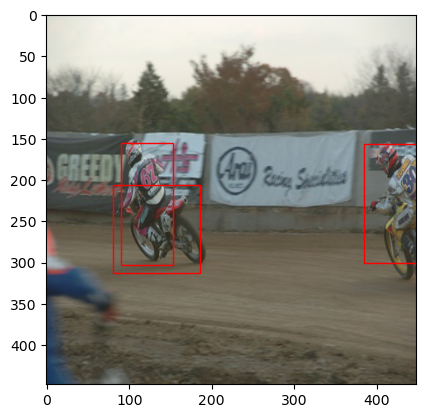

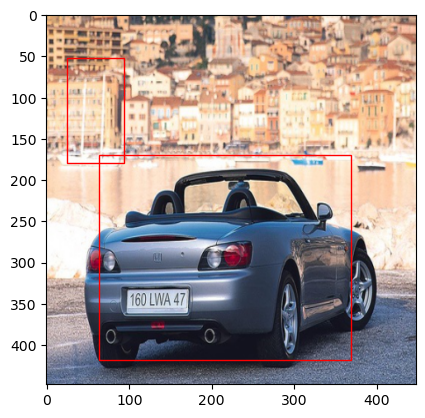

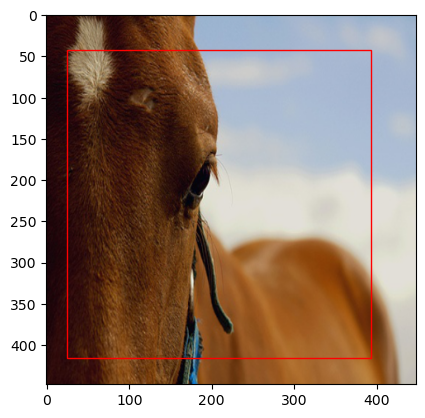

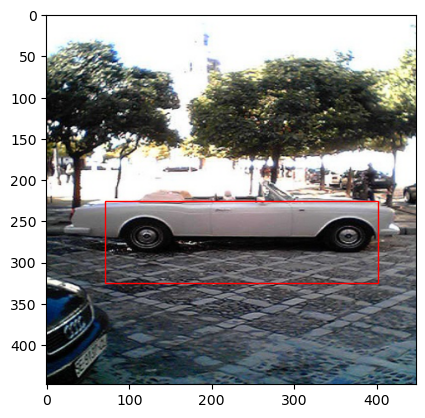

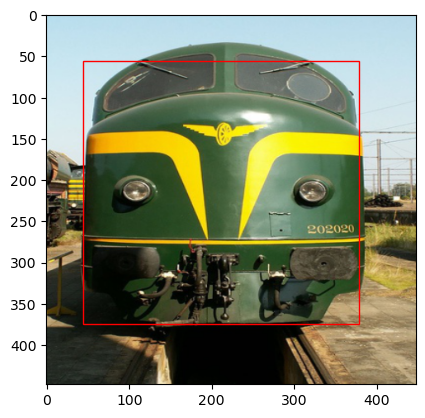

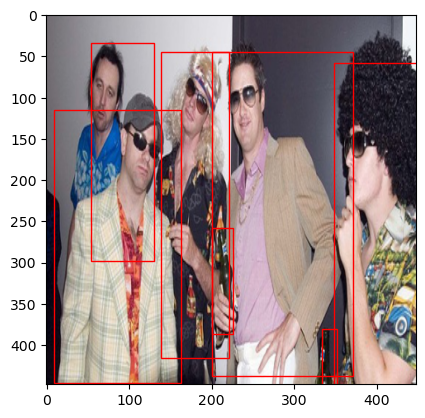

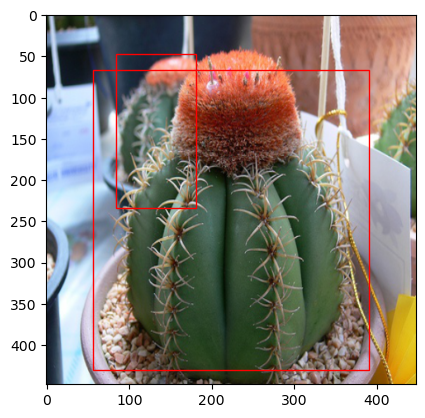

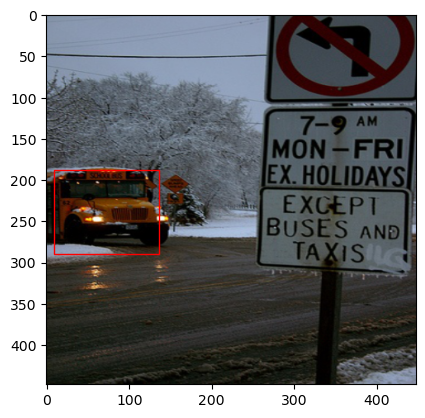

In [23]:
for x, y in train_loader:
    x = x.to(DEVICE)
    for idx in range(8):
        bboxes = cellboxes_to_boxes(model(x))
        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

    break

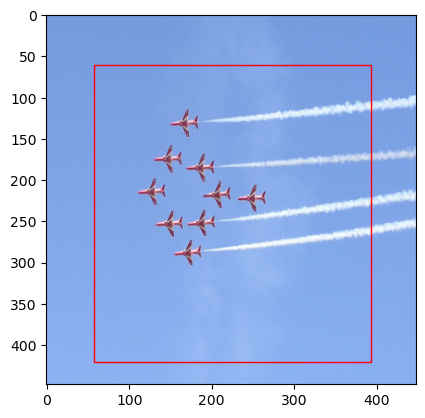

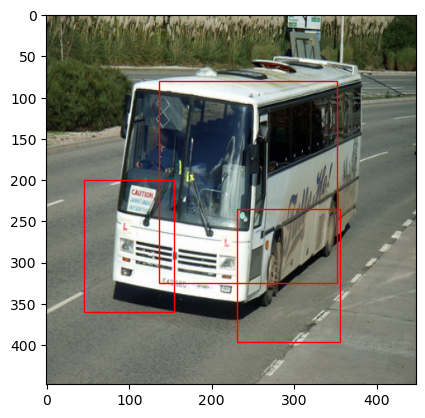

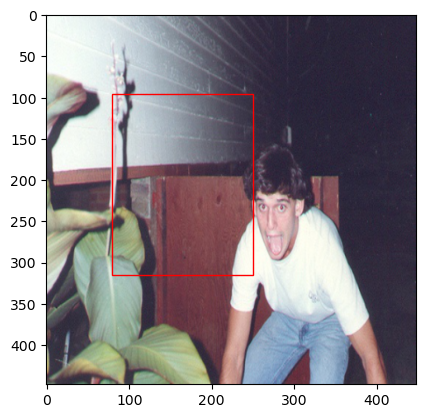

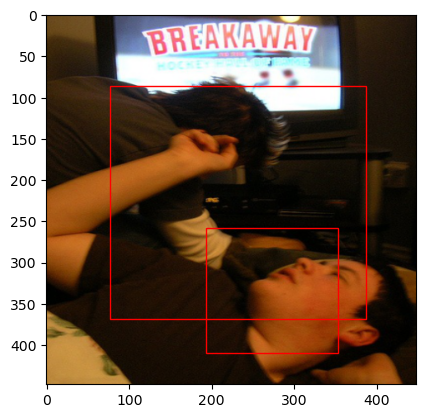

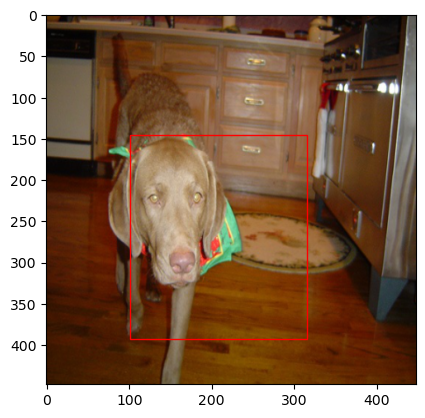

In [24]:
for x, y in test_loader:
    x = x.to(DEVICE)
    for idx in range(5):
        bboxes = cellboxes_to_boxes(model(x))
        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

    break

In [25]:
pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.5, threshold=0.4)

mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
print(f"Test mAP: {mean_avg_prec}")

Test mAP: 0.0011541384737938643


In [26]:
pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4)

mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
print(f"Train mAP: {mean_avg_prec}")

Train mAP: 0.49492016434669495
